In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import string


import numpy as np
import statistics as st
import glob
import sys
import io

import zipfile
import tarfile
import logging
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import contractions
import re

In [2]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Movies_and_TV.json.gz

In [3]:
#!pip install lxml

In [4]:
#!pip install contractions

In [5]:
def remove_urls(sentence):
    http_pattern = re.compile(r"http\S+") # Matches all words starting with 'http' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(http_pattern,'',sentence).strip()
    www_pattern = re.compile(r"www\S+") # Matches all words starting with 'www' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(www_pattern,'',cleaned_sentence).strip()
    return cleaned_sentence

def remove_html_entities(sentence):
    pattern = re.compile("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}")
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

def remove_words_with_repeated_characters(sentence): 
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    cleaned_text  = re.sub(pattern,'',sentence).strip()
    return (cleaned_text)

def expand_eng_contradictions(sentence):
    
    '''
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    '''
    
    return contractions.fix(sentence).strip()

def remove_special_characters_punctuations(sentence):
    
    pattern = re.compile(r"\r")
    cleaned_text  = re.sub(pattern,'',sentence).strip()
    
    pattern = re.compile(r"\S(\n)\S")
    cleaned_text  = re.sub(pattern,'',sentence).strip()
    
    pattern = re.compile(r"\u201C")
    cleaned_text  = re.sub(pattern,'',sentence).strip()
    
    pattern = re.compile(r"\u201D")
    cleaned_text  = re.sub(pattern,'',sentence).strip()
    
    pattern = re.compile(r'[' + string.punctuation + ']') # match a single character not present in the set (basically anything other than a-z and A-Z)
    cleaned_text  = re.sub(pattern,' ',sentence).strip()
    
    return " ".join(cleaned_text.split())

In [6]:
### load the meta data

##Change the path to the main archive data archive file accordingly

data = []
in_txt = ""
with gzip.open('Movies_and_TV.json.gz') as f:
    for l in f:
        in_txt = json.loads(l.strip())
        if in_txt and ("overall" in in_txt) and in_txt["overall"] and isinstance(in_txt["overall"], float) and ("reviewText" in in_txt) and in_txt["reviewText"]:
            in_txt["overall"] = float(in_txt["overall"])
            in_txt["reviewText"] = BeautifulSoup(in_txt["reviewText"].lower().strip(), "lxml").text
            in_txt["reviewText"] = remove_urls(in_txt["reviewText"])
            in_txt["reviewText"] = remove_html_entities(in_txt["reviewText"])
            in_txt["reviewText"] = remove_words_with_repeated_characters(in_txt["reviewText"])
            in_txt["reviewText"] = expand_eng_contradictions(in_txt["reviewText"])
            in_txt["reviewText"] = remove_special_characters_punctuations(in_txt["reviewText"])
            
            if len(in_txt["reviewText"].split())>4:
                if in_txt["overall"] < 3:
                    data.append({"reviewText":in_txt["reviewText"],  "label":0})
                else:
                    data.append({"reviewText":in_txt["reviewText"],  "label":1})
                
        #data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

d:\data\work\cognius\platformtest\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
d:\data\work\cognius\platformtest\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


7053583
{'reviewText': 'really happy they got evangelised spoiler alert happy ending liked that since started bit worrisome but yeah great stories these missionary movies really short only half hour but still great', 'label': 1}


# Data Explortaion

In [8]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

7053583


In [9]:
df.to_csv("initial_data.csv", encoding='utf-8', index=False)

In [4]:
#Load initial data
df = pd.read_csv("initial_data.csv", encoding='utf-8')

In [5]:
df

,reviewText,label
0,really happy they got evangelised spoiler aler...,1
1,having lived in west new guinea papua during t...,1
2,excellent look into contextualizing the gospel...,1
3,more than anything i have been challenged to f...,1
4,this is a great movie for a missionary going i...,1
...,...,...
7053578,set in a non existent country we meet el presi...,1
7053579,this 2014 film is just being released on dvd i...,1
7053580,instead of dealing with the legend in a manner...,0
7053581,my review is of the technical aspects of she w...,1


In [6]:
df_pos = df[df["label"]==1]
len(df_pos)

6138973

In [7]:
df_neg = df[df["label"]==0]
len(df_neg)

914610

In [8]:
len(df_pos[df_pos[["reviewText"]].duplicated()])

612142

In [9]:
df_pos_nodup = df_pos.drop_duplicates( "reviewText" , keep='first')

In [10]:
len(df_pos_nodup)

5526831

In [11]:
len(df_neg[df_neg[["reviewText"]].duplicated()])

68013

In [12]:
df_neg_nodup = df_neg.drop_duplicates( "reviewText" , keep='first')

In [13]:
len(df_neg_nodup)

846597

In [14]:
df_nodup_1 = pd.concat([df_pos_nodup, df_neg_nodup], ignore_index=True)

In [15]:
df_nodup_1

,reviewText,label
0,really happy they got evangelised spoiler aler...,1
1,having lived in west new guinea papua during t...,1
2,excellent look into contextualizing the gospel...,1
3,more than anything i have been challenged to f...,1
4,this is a great movie for a missionary going i...,1
...,...,...
6373423,rating it two stars because its a barbie movie...,0
6373424,nowhere on the order screen did it say this mo...,0
6373425,ok it is a christmas film and hallmark so we d...,0
6373426,two stars because the main actors were better ...,0


In [16]:
df_nodup_final = df_nodup_1.drop_duplicates( "reviewText" , keep=False)

In [17]:
len(df_nodup_final)

6368962

In [18]:
df_nodup_final

,reviewText,label
0,really happy they got evangelised spoiler aler...,1
1,having lived in west new guinea papua during t...,1
2,excellent look into contextualizing the gospel...,1
3,more than anything i have been challenged to f...,1
4,this is a great movie for a missionary going i...,1
...,...,...
6373423,rating it two stars because its a barbie movie...,0
6373424,nowhere on the order screen did it say this mo...,0
6373425,ok it is a christmas film and hallmark so we d...,0
6373426,two stars because the main actors were better ...,0


In [19]:
df_nodup_final.to_csv("data_remove_duplicates.csv", encoding='utf-8', index=False)

In [20]:
len("how are you".split())

3

In [21]:
df_nodup_final["sentLen"] = df_nodup_final["reviewText"].apply(lambda x: len(x.split()))

<ipython-input-21-25cdc4a135b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodup_final["sentLen"] = df_nodup_final["reviewText"].apply(lambda x: len(x.split()))


In [22]:
df_nodup_final

,reviewText,label,sentLen
0,really happy they got evangelised spoiler aler...,1,30
1,having lived in west new guinea papua during t...,1,41
2,excellent look into contextualizing the gospel...,1,30
3,more than anything i have been challenged to f...,1,34
4,this is a great movie for a missionary going i...,1,31
...,...,...,...
6373423,rating it two stars because its a barbie movie...,0,61
6373424,nowhere on the order screen did it say this mo...,0,49
6373425,ok it is a christmas film and hallmark so we d...,0,252
6373426,two stars because the main actors were better ...,0,215


In [23]:
df_nodup_final.to_csv("data_remove_duplicates.csv", encoding='utf-8', index=False)

In [24]:
word_count_total = Counter(df_nodup_final['sentLen'].tolist())


In [25]:
word_count_total

Counter({30: 78856,
         41: 46296,
         34: 62991,
         31: 73756,
         23: 140789,
         40: 48198,
         62: 24341,
         49: 34840,
         39: 50067,
         35: 59947,
         60: 25535,
         157: 5454,
         56: 28405,
         86: 14655,
         164: 5043,
         90: 13922,
         210: 3251,
         159: 5240,
         50: 33893,
         170: 4659,
         390: 897,
         42: 44608,
         122: 8413,
         235: 2605,
         51: 32939,
         279: 1861,
         91: 13582,
         44: 41109,
         121: 8460,
         76: 17472,
         110: 9820,
         83: 15589,
         70: 20316,
         33: 66212,
         173: 4626,
         14: 103737,
         166: 5026,
         25: 115929,
         335: 1255,
         6: 177977,
         5: 165149,
         52: 31818,
         13: 111563,
         8: 165827,
         26: 105849,
         28: 89934,
         20: 167605,
         29: 83216,
         32: 69604,
         258: 2

In [26]:
word_count_total.most_common()

[(6, 177977),
 (7, 175077),
 (21, 173070),
 (20, 167605),
 (8, 165827),
 (5, 165149),
 (22, 157056),
 (9, 155104),
 (10, 143900),
 (23, 140789),
 (11, 131981),
 (24, 127860),
 (12, 121002),
 (25, 115929),
 (13, 111563),
 (26, 105849),
 (14, 103737),
 (15, 98949),
 (27, 97625),
 (16, 92396),
 (28, 89934),
 (17, 85859),
 (19, 83433),
 (29, 83216),
 (18, 82337),
 (30, 78856),
 (31, 73756),
 (32, 69604),
 (33, 66212),
 (34, 62991),
 (35, 59947),
 (36, 57157),
 (37, 54924),
 (38, 52334),
 (39, 50067),
 (40, 48198),
 (41, 46296),
 (42, 44608),
 (43, 42886),
 (44, 41109),
 (45, 39898),
 (46, 38461),
 (47, 37294),
 (48, 35948),
 (49, 34840),
 (50, 33893),
 (51, 32939),
 (52, 31818),
 (53, 30882),
 (54, 29799),
 (55, 28987),
 (56, 28405),
 (57, 27467),
 (58, 26950),
 (59, 26258),
 (60, 25535),
 (61, 25044),
 (62, 24341),
 (63, 24045),
 (64, 23304),
 (65, 22557),
 (66, 22411),
 (67, 21571),
 (68, 21266),
 (69, 20950),
 (70, 20316),
 (71, 19838),
 (72, 19568),
 (73, 18920),
 (74, 18722),
 (75, 18

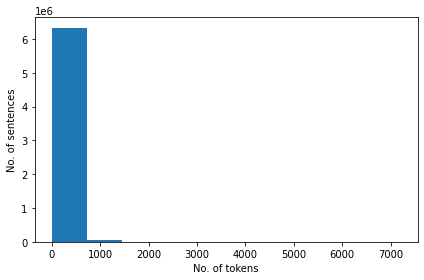

In [25]:
# Generating histogram for the distribution of number of tokens in sentences

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_nodup_final["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in sentences')

fig.tight_layout()
plt.show()

In [26]:
max(df_nodup_final["sentLen"].tolist())

7200

In [27]:
#if truncation of maximum length is required, can perform it here

df_nodup_final_trunc = df_nodup_final

In [28]:
df_nodup_final_trunc

,reviewText,label,sentLen
0,really happy they got evangelised spoiler aler...,1,30
1,having lived in west new guinea papua during t...,1,41
2,excellent look into contextualizing the gospel...,1,30
3,more than anything i have been challenged to f...,1,34
4,this is a great movie for a missionary going i...,1,31
...,...,...,...
6373423,rating it two stars because its a barbie movie...,0,61
6373424,nowhere on the order screen did it say this mo...,0,49
6373425,ok it is a christmas film and hallmark so we d...,0,252
6373426,two stars because the main actors were better ...,0,215


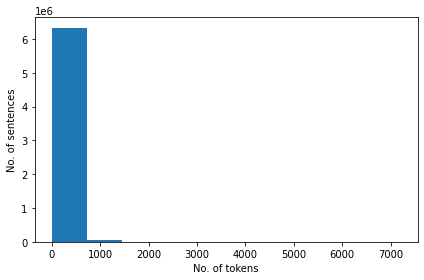

In [29]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_nodup_final_trunc["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [30]:
max(df_nodup_final_trunc["sentLen"].tolist())

7200

In [31]:
df_nodup_final_trunc.to_csv("data_remove_duplicates_truncated.csv", encoding='utf-8', index=False)

In [32]:
df_nodup_final_trunc = pd.read_csv("data_remove_duplicates_truncated.csv", encoding='utf-8')

In [32]:
df_neg_fin_1 = df_nodup_final_trunc[df_nodup_final_trunc["label"]==0]

In [33]:
df_neg_fin_1

,reviewText,label,sentLen
5526831,this dvd appears to be in german it is not in ...,0,28
5526832,this movie is not in english although the titl...,0,35
5526833,i usually do not like giving negative reviews ...,0,30
5526834,while there was a lot of information in this p...,0,97
5526835,the video has a half truth view the view of wo...,0,52
...,...,...,...
6373423,rating it two stars because its a barbie movie...,0,61
6373424,nowhere on the order screen did it say this mo...,0,49
6373425,ok it is a christmas film and hallmark so we d...,0,252
6373426,two stars because the main actors were better ...,0,215


In [34]:
len(df_neg_fin_1)

844364

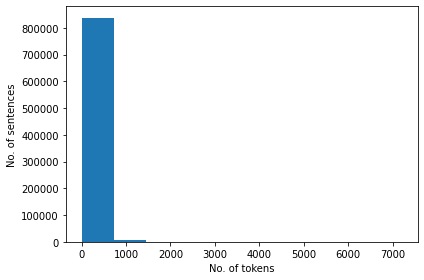

In [35]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_neg_fin_1["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [36]:
tot_neg_sent = len(df_neg_fin_1)

In [37]:
neg_count = dict(Counter(df_neg_fin_1['sentLen'].tolist()))

In [38]:
neg_count[27]

11639

In [39]:
neg_weights = []
for each in df_neg_fin_1['sentLen'].tolist():
    neg_weights.append(neg_count[each]/tot_neg_sent)
    

In [40]:
neg_weights

[0.0126829187412064,
 0.009331283664391187,
 0.01143227328498136,
 0.002501290912450081,
 0.005693042337191069,
 0.021174517151370736,
 0.020051778616805075,
 0.02054090415981733,
 0.011914292887901426,
 0.01660302902539663,
 0.013920536640595761,
 0.0126829187412064,
 0.006265070514612181,
 0.014663107380229379,
 0.021314267306517094,
 0.02162219137717856,
 0.005882534072982742,
 0.01660302902539663,
 0.014576651775774429,
 0.013920536640595761,
 0.020051778616805075,
 0.008653850708935956,
 0.011914292887901426,
 0.0031064801436347356,
 0.01660302902539663,
 0.021314267306517094,
 0.013253762595278813,
 0.018128437498519594,
 0.008653850708935956,
 0.015625962262720818,
 0.02054090415981733,
 0.012243534778839459,
 0.01143227328498136,
 0.0001492247419359423,
 0.004389102330274621,
 0.00901743797698623,
 0.006090974982353582,
 0.0030022596889493157,
 0.0004310936989260556,
 0.018611641424788362,
 0.0008515284877138296,
 0.005882534072982742,
 0.017602597931697703,
 0.0053282707457920

# Preparing Negative Data Files

In [41]:
df_neg_fin_1["neg_weights"] = neg_weights

<ipython-input-41-c80bb69ee335>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_fin_1["neg_weights"] = neg_weights


In [42]:
df_neg_fin_1

,reviewText,label,sentLen,neg_weights
5526831,this dvd appears to be in german it is not in ...,0,28,0.012683
5526832,this movie is not in english although the titl...,0,35,0.009331
5526833,i usually do not like giving negative reviews ...,0,30,0.011432
5526834,while there was a lot of information in this p...,0,97,0.002501
5526835,the video has a half truth view the view of wo...,0,52,0.005693
...,...,...,...,...
6373423,rating it two stars because its a barbie movie...,0,61,0.004627
6373424,nowhere on the order screen did it say this mo...,0,49,0.006091
6373425,ok it is a christmas film and hallmark so we d...,0,252,0.000429
6373426,two stars because the main actors were better ...,0,215,0.000532


In [43]:
df_neg_fin_1.to_csv("data_remove_duplicates_all_neg.csv", encoding='utf-8', index=False)

In [44]:
df_neg_fin_1_sampled = df_neg_fin_1.sample(n=25000, weights='neg_weights', random_state=123).reset_index(drop=True)

In [45]:
df_neg_fin_1_sampled

,reviewText,label,sentLen,neg_weights
0,weak plot predictable acting in short a waste ...,0,10,0.018734
1,it is supposed to come with 8 exclusive postca...,0,35,0.009331
2,not dubbed in english as specified bought used,0,8,0.021175
3,i stopped watching after 10 minutes acting and...,0,11,0.017603
4,not a lot of action i liked it husband was dis...,0,11,0.017603
...,...,...,...,...
24995,this is painful to watch terrible sets a sound...,0,25,0.015626
24996,you could just buy them individually as new dv...,0,23,0.018128
24997,i live in st pete area and this is worse depic...,0,18,0.011914
24998,i was looking forward to the story of how mose...,0,23,0.018128


In [46]:
df_new_neg_fin_1 = df_neg_fin_1.merge(df_neg_fin_1_sampled, how='left', indicator=True)
df_new_neg_fin_1  = df_new_neg_fin_1[df_new_neg_fin_1['_merge'] == 'left_only']

In [47]:
df_new_neg_fin_1

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
844359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
844360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
844361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
844362,two stars because the main actors were better ...,0,215,0.000532,left_only


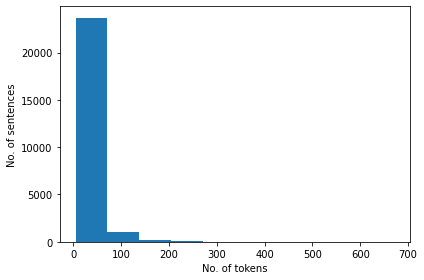

In [48]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_neg_fin_1_sampled["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [49]:
df_neg_fin_1_sampled.to_csv("../data/1_data_remove_duplicates_25_neg_sampled.csv", encoding='utf-8', index=False)

In [50]:
df_neg_fin_1_sampled_2 = df_new_neg_fin_1.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [51]:
df_neg_fin_1_sampled_2

,reviewText,label,sentLen,neg_weights
0,no climax whatsoever no pun intended,0,6,0.021314
1,i stopped watching the movie after many theolo...,0,9,0.020052
2,mildly interesting but novice efforts in writi...,0,10,0.018734
3,i was very disappointed with the content of th...,0,63,0.004670
4,if you are looking for a good movie to watch k...,0,12,0.016603
...,...,...,...,...
4995,d are a g s on not a very good set up and no r...,0,32,0.010426
4996,absolutely the most disturbingly and confusing...,0,24,0.016884
4997,ben affleck is the worst i would gladly pay tw...,0,19,0.011712
4998,the casting was subpar and the story went forw...,0,13,0.015306


In [52]:
df_neg_fin_1_sampled_2.to_csv("../data/1_data_remove_duplicates_5_neg_sampled_val.csv", encoding='utf-8', index=False)

In [53]:
df_new_neg_fin_2 = df_new_neg_fin_1[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_2, how='left', indicator=True)
df_new_neg_fin_2  = df_new_neg_fin_2[df_new_neg_fin_2['_merge'] == 'left_only']

In [54]:
df_new_neg_fin_2

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
819359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
819360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
819361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
819362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [55]:
df_neg_fin_1_sampled_3 = df_new_neg_fin_2.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [56]:
df_neg_fin_1_sampled_3

,reviewText,label,sentLen,neg_weights
0,slow moving low budget we turned it off,0,8,0.021175
1,this started out as enjoyable and seemed like ...,0,79,0.003324
2,they need to do a better transfer of this movi...,0,22,0.019858
3,once again i was looking for something interes...,0,34,0.009625
4,movie seems to be a little cheesy,0,7,0.021622
...,...,...,...,...
4995,i am not able to view the dvd selections my pl...,0,39,0.008180
4996,its not playing we tried defferent dvds player...,0,28,0.012683
4997,please do not bother to buy it buy the new the...,0,22,0.019858
4998,not the best in the series,0,6,0.021314


In [57]:
df_neg_fin_1_sampled_3.to_csv("../data/1_data_remove_duplicates_5_neg_sampled_test.csv", encoding='utf-8', index=False)

In [58]:
df_new_neg_fin_3 = df_new_neg_fin_2[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_3, how='left', indicator=True)
df_new_neg_fin_3  = df_new_neg_fin_3[df_new_neg_fin_3['_merge'] == 'left_only']


In [59]:
df_new_neg_fin_3

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
814359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
814360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
814361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
814362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [60]:
df_neg_fin_1_sampled_4 = df_new_neg_fin_3.sample(n=25000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [61]:
df_neg_fin_1_sampled_4


,reviewText,label,sentLen,neg_weights
0,nothing could play this dvd i eventually just ...,0,16,0.013254
1,scream of fear and 2 faces of dr jekyll barely...,0,65,0.004389
2,but the screen play was not the series with gl...,0,21,0.020541
3,it was ok i just never really got that interes...,0,21,0.020541
4,forgot how boring this was is,0,6,0.021314
...,...,...,...,...
24995,the movie case was crushed and the movie insid...,0,24,0.016884
24996,the company i ordered this from did not come t...,0,45,0.006825
24997,the story line is such a stretch i could not f...,0,24,0.016884
24998,i was very disappointed with this interpretati...,0,10,0.018734


In [62]:
df_neg_fin_1_sampled_4.to_csv("../data/2_data_remove_duplicates_25_neg_sampled.csv", encoding='utf-8', index=False)

In [80]:
df_new_neg_fin_4 = df_new_neg_fin_3[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_4, how='left', indicator=True)
df_new_neg_fin_4  = df_new_neg_fin_4[df_new_neg_fin_4['_merge'] == 'left_only']


In [81]:
df_new_neg_fin_4

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
809359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
809360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
809361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
809362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [82]:
df_neg_fin_1_sampled_5 = df_new_neg_fin_4.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [83]:
df_neg_fin_1_sampled_5


,reviewText,label,sentLen,neg_weights
0,unrealistic boring characters are not likable,0,6,0.021314
1,very boring i thought it would never end,0,8,0.021175
2,i do not like reality type shows remember thos...,0,14,0.014663
3,not worth all the hype awards pretty much just...,0,23,0.018128
4,boring poorly acted and ridiculous plot i woul...,0,19,0.011712
...,...,...,...,...
4995,love maggie smith but oh my the movie was so w...,0,33,0.009971
4996,i did not know what to expect from this movie ...,0,36,0.009017
4997,had great potential but the ending fell flat c...,0,20,0.018612
4998,amateurish stinkeroo of a courtroom drama the ...,0,52,0.005693


In [84]:
df_neg_fin_1_sampled_5.to_csv("../data/2_data_remove_duplicates_5_neg_sampled_val.csv", encoding='utf-8', index=False)

In [85]:
df_new_neg_fin_5 = df_new_neg_fin_4[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_5, how='left', indicator=True)
df_new_neg_fin_5  = df_new_neg_fin_5[df_new_neg_fin_5['_merge'] == 'left_only']



In [86]:
df_new_neg_fin_5

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
784359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
784360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
784361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
784362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [87]:
df_neg_fin_1_sampled_6 = df_new_neg_fin_5.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [88]:
df_neg_fin_1_sampled_6


,reviewText,label,sentLen,neg_weights
0,could not finish it there was no redeeming qua...,0,12,0.016603
1,my first purchase online of a used blue ray dv...,0,30,0.011432
2,i turned this show off after about 10 15 minut...,0,24,0.016884
3,this was a lame excuse for a thriller i kept h...,0,31,0.010758
4,this movie was painful brutal thin plot and ju...,0,26,0.014577
...,...,...,...,...
4995,it amazes me that a whole film with great acto...,0,38,0.008319
4996,too scratched up out of the box had to return it,0,11,0.017603
4997,the movement from his early years to the latte...,0,15,0.013921
4998,s ty film clones looked like drunk all film lo...,0,21,0.020541


In [89]:
df_neg_fin_1_sampled_6.to_csv("../data/2_data_remove_duplicates_5_neg_sampled_test.csv", encoding='utf-8', index=False)

In [90]:
df_new_neg_fin_6 = df_new_neg_fin_5[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_6, how='left', indicator=True)
df_new_neg_fin_6  = df_new_neg_fin_6[df_new_neg_fin_6['_merge'] == 'left_only']



In [91]:
df_new_neg_fin_6

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
779359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
779360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
779361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
779362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [92]:
df_neg_fin_1_sampled_7 = df_new_neg_fin_6.sample(n=25000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [93]:
df_neg_fin_1_sampled_7


,reviewText,label,sentLen,neg_weights
0,uugh not sure what to make of this trainwreck,0,9,0.020052
1,awful if you know nothing about star trek this...,0,21,0.020541
2,just weird and did not really make much sense,0,9,0.020052
3,yawn started off good then spiraled into a cla...,0,30,0.011432
4,pretty boring really hardly seems to fit the s...,0,14,0.014663
...,...,...,...,...
24995,are you kidding me 500 for a used the office s...,0,52,0.005693
24996,put it on for the kids then leave the room bor...,0,37,0.008654
24997,the story line did not keep me interested move...,0,22,0.019858
24998,the later seasons are not very good at all,0,9,0.020052


In [94]:
df_neg_fin_1_sampled_7.to_csv("../data/3_data_remove_duplicates_25_neg_sampled.csv", encoding='utf-8', index=False)

In [95]:
df_new_neg_fin_7 = df_new_neg_fin_6[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_7, how='left', indicator=True)
df_new_neg_fin_7  = df_new_neg_fin_7[df_new_neg_fin_7['_merge'] == 'left_only']



In [96]:
df_new_neg_fin_7

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
774359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
774360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
774361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
774362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [97]:
df_neg_fin_1_sampled_8 = df_new_neg_fin_7.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [98]:
df_neg_fin_1_sampled_8


,reviewText,label,sentLen,neg_weights
0,superdumb he did not even spank her hard,0,8,0.021175
1,i think 10 minutes were watched and the rest i...,0,21,0.020541
2,my 5 year old grandaughter loved it,0,7,0.021622
3,too much presumption presented as fact far bet...,0,28,0.012683
4,so what was ayn rand trying to say,0,8,0.021175
...,...,...,...,...
4995,even for a b movie this was bad,0,8,0.021175
4996,oh something to watch not the greatest,0,7,0.021622
4997,this movie dragged it was cute and funny in so...,0,23,0.018128
4998,very badly produced film not worth your time s...,0,20,0.018612


In [99]:
df_neg_fin_1_sampled_8.to_csv("../data/3_data_remove_duplicates_5_neg_sampled_val.csv", encoding='utf-8', index=False)

In [100]:
df_new_neg_fin_8 = df_new_neg_fin_7[["reviewText","label","sentLen","neg_weights"]].merge(df_neg_fin_1_sampled_8, how='left', indicator=True)
df_new_neg_fin_8  = df_new_neg_fin_8[df_new_neg_fin_8['_merge'] == 'left_only']



In [101]:
df_new_neg_fin_8

,reviewText,label,sentLen,neg_weights,_merge
0,this dvd appears to be in german it is not in ...,0,28,0.012683,left_only
1,this movie is not in english although the titl...,0,35,0.009331,left_only
2,i usually do not like giving negative reviews ...,0,30,0.011432,left_only
3,while there was a lot of information in this p...,0,97,0.002501,left_only
4,the video has a half truth view the view of wo...,0,52,0.005693,left_only
...,...,...,...,...,...
749359,rating it two stars because its a barbie movie...,0,61,0.004627,left_only
749360,nowhere on the order screen did it say this mo...,0,49,0.006091,left_only
749361,ok it is a christmas film and hallmark so we d...,0,252,0.000429,left_only
749362,two stars because the main actors were better ...,0,215,0.000532,left_only


In [102]:
df_neg_fin_1_sampled_9 = df_new_neg_fin_8.sample(n=5000, weights='neg_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])


In [103]:
df_neg_fin_1_sampled_9


,reviewText,label,sentLen,neg_weights
0,did not like good actors but perhaps like the ...,0,17,0.012553
1,very stupid and boring effects its was so bori...,0,22,0.019858
2,is this the worst movie ever made well there w...,0,26,0.014577
3,the movie that plays is not the cloth some b g...,0,23,0.018128
4,it was like watching a soap opera,0,7,0.021622
...,...,...,...,...
4995,false advertising only one movie from steven s...,0,27,0.013784
4996,they are amongst my favorite unfortunately the...,0,25,0.015626
4997,i liked the movie and all but i have seen scar...,0,23,0.018128
4998,3d was not any good i did not like any part of...,0,14,0.014663


In [104]:
df_neg_fin_1_sampled_9.to_csv("../data/3_data_remove_duplicates_5_neg_sampled_test.csv", encoding='utf-8', index=False)

# Preparing Positive Data Files

In [105]:
df_pos_fin_1 = df_nodup_final_trunc[df_nodup_final_trunc["label"]==1]

In [106]:
len(df_pos_fin_1)

5524598

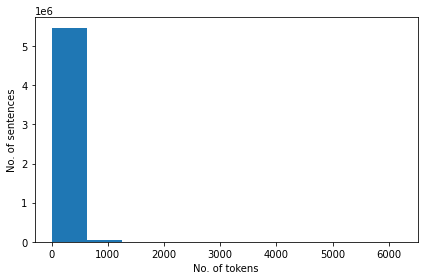

In [107]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_pos_fin_1["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [108]:
tot_pos_sent = len(df_pos_fin_1)



In [109]:
pos_count = dict(Counter(df_pos_fin_1['sentLen'].tolist()))



In [110]:
pos_count



{30: 69203,
 41: 39930,
 34: 54864,
 31: 64672,
 23: 125482,
 40: 41564,
 62: 20521,
 49: 29697,
 39: 43160,
 35: 52068,
 60: 21497,
 157: 4502,
 56: 23906,
 86: 12204,
 164: 4180,
 90: 11607,
 210: 2740,
 159: 4337,
 50: 28909,
 170: 3856,
 390: 761,
 42: 38343,
 122: 6942,
 235: 2183,
 51: 27972,
 279: 1533,
 91: 11248,
 44: 35139,
 121: 6996,
 76: 14609,
 110: 8037,
 83: 13047,
 70: 16966,
 33: 57793,
 173: 3810,
 14: 91356,
 166: 4118,
 25: 102735,
 335: 1058,
 6: 159980,
 5: 148337,
 52: 27011,
 13: 98639,
 8: 147948,
 26: 93541,
 28: 79225,
 20: 151890,
 29: 72878,
 32: 60801,
 258: 1762,
 69: 17656,
 54: 25261,
 21: 155726,
 63: 20102,
 46: 32995,
 18: 72277,
 158: 4443,
 124: 6734,
 109: 8293,
 389: 789,
 105: 8815,
 75: 15208,
 7: 156820,
 11: 117118,
 9: 138173,
 10: 128082,
 246: 1945,
 106: 8749,
 27: 85986,
 16: 81205,
 17: 75260,
 61: 21137,
 163: 4057,
 149: 4801,
 192: 3099,
 191: 3224,
 144: 5199,
 79: 13981,
 47: 31805,
 45: 34135,
 37: 47617,
 22: 140289,
 12: 106983

In [111]:
pos_weights = []
for each in df_pos_fin_1['sentLen'].tolist():
    pos_weights.append(pos_count[each]/tot_pos_sent)
    



In [112]:
pos_weights


[0.012526341283112363,
 0.007227675208223295,
 0.012526341283112363,
 0.009930858317654967,
 0.011706191111099848,
 0.02271332683391624,
 0.007523443334700552,
 0.0037144784109178625,
 0.005375413740511074,
 0.007812333132655082,
 0.009424758145298535,
 0.0038911428487647427,
 0.000814900921297803,
 0.004327192675376562,
 0.002209029507667345,
 0.0007566161374999592,
 0.002100967346402399,
 0.0004959636882176766,
 0.0007850344948175414,
 0.005232778927987159,
 0.0006979693364114457,
 0.00013774757909987298,
 0.006940414488076779,
 0.007227675208223295,
 0.001256562015915004,
 0.00039514187276612706,
 0.00506317382730834,
 0.00027748625329843005,
 0.002035985242727163,
 0.0063604627884237,
 0.0012663364827630898,
 0.002644355299697824,
 0.00145476648255674,
 0.0023616197956846815,
 0.003070992676752227,
 0.010461032639840944,
 0.0006896429387260395,
 0.016536225803216814,
 0.0007453936014891943,
 0.01859592317848285,
 0.00019150714676434376,
 0.02895776308068026,
 0.026850279423045804,


In [113]:
df_pos_fin_1["pos_weights"] = pos_weights

<ipython-input-113-40e8c5db1773>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_fin_1["pos_weights"] = pos_weights


In [114]:
df_pos_fin_1

,reviewText,label,sentLen,pos_weights
0,really happy they got evangelised spoiler aler...,1,30,0.012526
1,having lived in west new guinea papua during t...,1,41,0.007228
2,excellent look into contextualizing the gospel...,1,30,0.012526
3,more than anything i have been challenged to f...,1,34,0.009931
4,this is a great movie for a missionary going i...,1,31,0.011706
...,...,...,...,...
5526826,makhmalbaf is at his finest and weaves a story...,1,21,0.028188
5526827,set in a non existent country we meet el presi...,1,283,0.000270
5526828,this 2014 film is just being released on dvd i...,1,480,0.000091
5526829,my review is of the technical aspects of she w...,1,226,0.000425


In [115]:
df_pos_fin_1.to_csv("data_remove_duplicates_all_pos.csv", encoding='utf-8', index=False)

In [116]:
df_pos_fin_1_sampled = df_pos_fin_1.sample(n=25000, weights='pos_weights', random_state=123).reset_index(drop=True)


In [117]:
df_pos_fin_1_sampled

,reviewText,label,sentLen,pos_weights
0,peter berg was the right director for this fil...,1,27,0.015564
1,this is a good almost hour long stand up dvd h...,1,71,0.002996
2,laughing too hard to write,1,5,0.026850
3,wanted did so badly i did the whole pre order ...,1,27,0.015564
4,worth a watch insightful view of b netanyahu s...,1,21,0.028188
...,...,...,...,...
24995,good mix of comedy drama,1,5,0.026850
24996,i love this show something different every time,1,8,0.026780
24997,excellent movie would watch it again,1,6,0.028958
24998,cute but feel like they could have done so muc...,1,13,0.017855


In [118]:
df_new_pos_fin_1 = df_pos_fin_1.merge(df_pos_fin_1_sampled, how='left', indicator=True)
df_new_pos_fin_1  = df_new_pos_fin_1[df_new_pos_fin_1['_merge'] == 'left_only']

In [119]:
df_new_pos_fin_1 

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5524593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5524594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5524595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5524596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


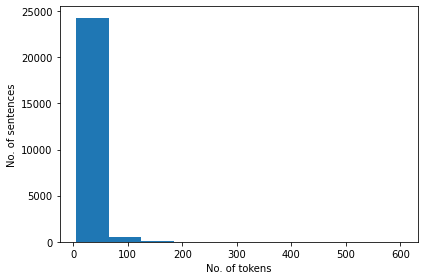

In [120]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 1000

ax.hist(np.array(df_pos_fin_1_sampled["sentLen"].tolist()), histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of sentences')
#ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [121]:
df_pos_fin_1_sampled.to_csv("../data/1_data_remove_duplicates_25_pos_sampled.csv", encoding='utf-8', index=False)

In [122]:
df_pos_fin_1_sampled_2 = df_new_pos_fin_1.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [123]:
df_pos_fin_1_sampled_2

,reviewText,label,sentLen,pos_weights
0,definitely a guy flick lots of action,1,7,0.028386
1,arrived on time the boondocks are the s,1,8,0.026780
2,hilariously hilarious two thumbs up,1,5,0.026850
3,my kids love the leap frog videos they have le...,1,21,0.028188
4,nice christmas gift and my niece loved it,1,8,0.026780
...,...,...,...,...
4995,it was one of the best shows when it originall...,1,21,0.028188
4996,movie was great but extra content was too much,1,9,0.025011
4997,great movie for entire family enchanting and m...,1,24,0.020563
4998,very good scripting photography casting storyl...,1,8,0.026780


In [124]:
df_pos_fin_1_sampled_2.to_csv("../data/1_data_remove_duplicates_5_pos_sampled_val.csv", encoding='utf-8', index=False)

In [125]:
df_new_pos_fin_2 = df_new_pos_fin_1[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_2, how='left', indicator=True)
df_new_pos_fin_2  = df_new_pos_fin_2[df_new_pos_fin_2['_merge'] == 'left_only']

In [126]:
df_new_pos_fin_2

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5499593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5499594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5499595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5499596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [127]:
df_pos_fin_1_sampled_3 = df_new_pos_fin_2.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [128]:
df_pos_fin_1_sampled_3

,reviewText,label,sentLen,pos_weights
0,great acting suspenseful great story character...,1,9,0.025011
1,the original boondocks were hilarious you will...,1,11,0.021199
2,this guy should never leave the house,1,7,0.028386
3,learning threw cartoons is fun,1,5,0.026850
4,this is like a travelogue of israel its topogr...,1,71,0.002996
...,...,...,...,...
4995,this is easy to follow and simple visuals that...,1,21,0.028188
4996,excellent as an 80 s child this is a favorite ...,1,21,0.028188
4997,too bad it was not an academy winner,1,8,0.026780
4998,it is one of my favorite shows raw emotions an...,1,41,0.007228


In [129]:
df_pos_fin_1_sampled_3.to_csv("../data/1_data_remove_duplicates_5_pos_sampled_test.csv", encoding='utf-8', index=False)

In [130]:
df_new_pos_fin_3 = df_new_pos_fin_2[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_3, how='left', indicator=True)
df_new_pos_fin_3  = df_new_pos_fin_3[df_new_pos_fin_3['_merge'] == 'left_only']

In [131]:
df_new_pos_fin_3

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5494593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5494594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5494595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5494596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [132]:
import math
math.floor(21*0.4)

8

In [133]:
21*0.4

8.4

In [134]:
df_pos_fin_1_sampled_4 = df_new_pos_fin_3.sample(n=25000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [135]:
df_pos_fin_1_sampled_4

,reviewText,label,sentLen,pos_weights
0,excellent however was not in hd,1,6,0.028958
1,loved it loved it this box set was a gift to m...,1,21,0.028188
2,a great trilogy of movies,1,5,0.026850
3,wonderful movie just wish it had closed cation...,1,20,0.027493
4,love this show tatiana maslany is really an am...,1,10,0.023184
...,...,...,...,...
24995,such a good show cannot wait to start the next...,1,11,0.021199
24996,excellent movie by the coen brothers a classic...,1,12,0.019365
24997,good you need to watch it,1,6,0.028958
24998,i would rate it higher if i could,1,8,0.026780


In [136]:
df_pos_fin_1_sampled_4.to_csv("../data/2_data_remove_duplicates_25_pos_sampled.csv", encoding='utf-8', index=False)

In [137]:
df_new_pos_fin_4 = df_new_pos_fin_3[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_4, how='left', indicator=True)
df_new_pos_fin_4  = df_new_pos_fin_4[df_new_pos_fin_4['_merge'] == 'left_only']

In [138]:
df_new_pos_fin_4

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5489593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5489594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5489595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5489596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [139]:
df_pos_fin_1_sampled_5 = df_new_pos_fin_4.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [140]:
df_pos_fin_1_sampled_5

,reviewText,label,sentLen,pos_weights
0,this movie is really good but so sad wish life...,1,14,0.016536
1,cool adaptation but more scenes were needed,1,7,0.028386
2,as funny as it was when i watched on hbo,1,10,0.023184
3,classic movie about disabilities and a strange...,1,23,0.022713
4,i am definitely buying season 3 this actress d...,1,12,0.019365
...,...,...,...,...
4995,beulah land is an amazing movie i really loved...,1,12,0.019365
4996,reluctantly watched with my spouse but soon fo...,1,11,0.021199
4997,i love it more the second time around,1,8,0.026780
4998,it is a mixture of comedy action drama and sci...,1,11,0.021199


In [141]:
df_pos_fin_1_sampled_5.to_csv("../data/2_data_remove_duplicates_5_pos_sampled_val.csv", encoding='utf-8', index=False)

In [142]:
df_new_pos_fin_5 = df_new_pos_fin_4[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_5, how='left', indicator=True)
df_new_pos_fin_5  = df_new_pos_fin_5[df_new_pos_fin_5['_merge'] == 'left_only']

In [143]:
df_new_pos_fin_5

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5464593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5464594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5464595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5464596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [144]:
df_pos_fin_1_sampled_6 = df_new_pos_fin_5.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [145]:
df_pos_fin_1_sampled_6

,reviewText,label,sentLen,pos_weights
0,love this movie had me on the edge of my seat ...,1,15,0.015783
1,i thought this would be really dumb but i love...,1,19,0.013312
2,exactly whati wanted very pleased,1,5,0.026850
3,one of the best movies i have seen this decade,1,10,0.023184
4,it just gets better and better as you watch,1,9,0.025011
...,...,...,...,...
4995,great fun movie worth seeing again,1,6,0.028958
4996,so fun and enjoyable felt like i was in india,1,10,0.023184
4997,ok but a little too bizzare,1,6,0.028958
4998,love the idea have not watched it all yet but ...,1,12,0.019365


In [146]:
df_pos_fin_1_sampled_6.to_csv("../data/2_data_remove_duplicates_5_pos_sampled_test.csv", encoding='utf-8', index=False)

In [147]:
df_new_pos_fin_6 = df_new_pos_fin_5[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_6, how='left', indicator=True)
df_new_pos_fin_6  = df_new_pos_fin_6[df_new_pos_fin_6['_merge'] == 'left_only']

In [148]:
df_new_pos_fin_6

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5459593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5459594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5459595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5459596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [149]:
df_pos_fin_1_sampled_7 = df_new_pos_fin_6.sample(n=25000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [150]:
df_pos_fin_1_sampled_7

,reviewText,label,sentLen,pos_weights
0,i am a nam vet this movie rocks it brought bac...,1,14,0.016536
1,the crazy antics never end with this series if...,1,24,0.020563
2,great show if a bit crude intentionally so lov...,1,10,0.023184
3,very good message and movie,1,5,0.026850
4,great show young lead and so accomplished,1,7,0.028386
...,...,...,...,...
24995,not a good story they basically swapped out su...,1,28,0.014340
24996,the second season of terminator is better than...,1,206,0.000482
24997,i had watched it when the show first came out ...,1,20,0.027493
24998,very imaginative i really loved the what if pr...,1,9,0.025011


In [151]:
df_pos_fin_1_sampled_7.to_csv("../data/3_data_remove_duplicates_25_pos_sampled.csv", encoding='utf-8', index=False)

In [152]:
df_new_pos_fin_7 = df_new_pos_fin_6[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_7, how='left', indicator=True)
df_new_pos_fin_7  = df_new_pos_fin_7[df_new_pos_fin_7['_merge'] == 'left_only']

In [153]:
df_new_pos_fin_7

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5454593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5454594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5454595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5454596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [154]:
df_pos_fin_1_sampled_8 = df_new_pos_fin_7.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [155]:
df_pos_fin_1_sampled_8

,reviewText,label,sentLen,pos_weights
0,martial arts fantasy monsters and creatures ab...,1,37,0.008619
1,these two take humor to another level very fun...,1,25,0.018596
2,came undamaged and absolutely perfect product ...,1,15,0.015783
3,great follow up to forks over knives,1,7,0.028386
4,awesome plot keeps you wanting to binge watch,1,8,0.026780
...,...,...,...,...
4995,i think i expected way more,1,6,0.028958
4996,errol morris did his homework for this movie 2...,1,138,0.001034
4997,my new favorite super hero,1,5,0.026850
4998,dune was a bonus was looking for that one,1,9,0.025011


In [156]:
df_pos_fin_1_sampled_8.to_csv("../data/3_data_remove_duplicates_5_pos_sampled_val.csv", encoding='utf-8', index=False)

In [157]:
df_new_pos_fin_8 = df_new_pos_fin_7[["reviewText","label","sentLen","pos_weights"]].merge(df_pos_fin_1_sampled_8, how='left', indicator=True)
df_new_pos_fin_8  = df_new_pos_fin_8[df_new_pos_fin_8['_merge'] == 'left_only']

In [158]:
df_new_pos_fin_8

,reviewText,label,sentLen,pos_weights,_merge
0,really happy they got evangelised spoiler aler...,1,30,0.012526,left_only
1,having lived in west new guinea papua during t...,1,41,0.007228,left_only
2,excellent look into contextualizing the gospel...,1,30,0.012526,left_only
3,more than anything i have been challenged to f...,1,34,0.009931,left_only
4,this is a great movie for a missionary going i...,1,31,0.011706,left_only
...,...,...,...,...,...
5429593,makhmalbaf is at his finest and weaves a story...,1,21,0.028188,left_only
5429594,set in a non existent country we meet el presi...,1,283,0.000270,left_only
5429595,this 2014 film is just being released on dvd i...,1,480,0.000091,left_only
5429596,my review is of the technical aspects of she w...,1,226,0.000425,left_only


In [159]:
df_pos_fin_1_sampled_9 = df_new_pos_fin_8.sample(n=5000, weights='pos_weights', random_state=123).reset_index(drop=True).drop(columns=["_merge"])

In [160]:
df_pos_fin_1_sampled_9

,reviewText,label,sentLen,pos_weights
0,my husband got this movie for himself and enjo...,1,22,0.025394
1,i absolutely adore little britain these two gu...,1,21,0.028188
2,i can watch these over and over and crack up a...,1,14,0.016536
3,these tv type adventure animated shows are lit...,1,23,0.022713
4,um yeah nothing better like seriously this sho...,1,10,0.023184
...,...,...,...,...
4995,this was an awesome movie that i would recomme...,1,22,0.025394
4996,always keeps you guessing great series,1,6,0.028958
4997,i thought the film was great,1,6,0.028958
4998,asimov could have prevented this,1,5,0.026850


In [161]:
df_pos_fin_1_sampled_9.to_csv("../data/3_data_remove_duplicates_5_pos_sampled_test.csv", encoding='utf-8', index=False)